# 3
## 3.6
### 3.6.2

In [95]:
import torch
import gpytorch
from gpytorch.models import ExactGP
import matplotlib.pyplot as plt
import numpy as np
import japanize_matplotlib

Text(0, 0.5, '$y$')

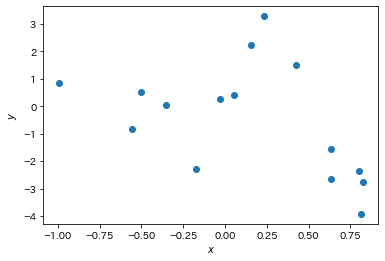

In [114]:
N = 15

x_data = torch.FloatTensor(N).uniform_(-1, 1)

def true_func(x):
    return 1.5*torch.exp(x) * torch.sin(2*torch.pi * x)

y_data = true_func(x_data) + 0.1+ torch.randn(N)

plt.scatter(x_data, y_data)
plt.xlabel("$x$")
plt.ylabel("$y$")

In [115]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        
        self.mean_module = gpytorch.means.ConstantMean()
        self.cover_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
        
    def forward(self, x):
        mean_x = self.mean_module(x)
        cover_x = self.cover_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, cover_x)
    
likelihood = gpytorch.likelihoods.GaussianLikelihood()

model = ExactGPModel(x_data, y_data, likelihood)

0 :theta_1 0.7444967031478882
0 :theta_2 0.6443966627120972
10 :theta_1 1.2592283487319946
10 :theta_2 0.2923690378665924
20 :theta_1 1.47804856300354
20 :theta_2 0.162204772233963
30 :theta_1 1.4394646883010864
30 :theta_2 0.14210590720176697
40 :theta_1 1.2829022407531738
40 :theta_2 0.16346609592437744
50 :theta_1 1.0819891691207886
50 :theta_2 0.19981423020362854
60 :theta_1 0.8877375721931458
60 :theta_2 0.21516336500644684
70 :theta_1 0.7342263460159302
70 :theta_2 0.20237430930137634
80 :theta_1 0.6317651867866516
80 :theta_2 0.19486838579177856
90 :theta_1 0.5795990228652954
90 :theta_2 0.19837625324726105
100 :theta_1 0.567624568939209
100 :theta_2 0.20055173337459564
110 :theta_1 0.5763856172561646
110 :theta_2 0.19992807507514954
120 :theta_1 0.5875746607780457
120 :theta_2 0.20103614032268524
130 :theta_1 0.5935288667678833
130 :theta_2 0.20245493948459625
140 :theta_1 0.5944130420684814
140 :theta_2 0.2024488002061844


Text(0, 0.5, 'Loss')

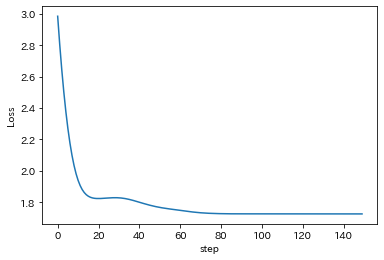

In [116]:
model.train()
likelihood.train()

optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

training_iter = 150
loss_list = []
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_data)
    loss = -mll(output, y_data)
    
    loss.backward()
    
    optimizer.step()
    loss_list.append(loss.to('cpu').detach().numpy().copy())
    if i%10==0:        
        print(i, ":theta_1", model.likelihood.noise.item())
        print(i, ":theta_2", model.cover_module.base_kernel.lengthscale.item())
    
plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("Loss")

In [117]:
model.eval()
likelihood.eval()

x_new = torch.linspace(-1, 1, 50)

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    prediction = likelihood(model(x_new))
    lower, upper = prediction.confidence_region()

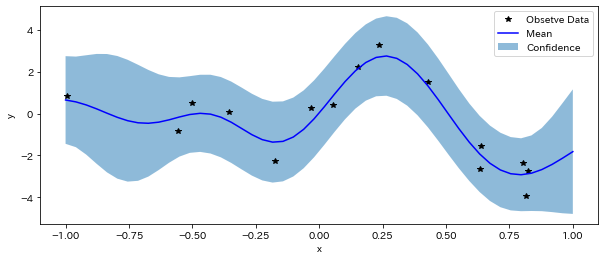

In [118]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(x_data.numpy(), y_data.numpy(), 'k*', label= 'Obsetve Data')
ax.plot(x_new.numpy(), prediction.mean.numpy(), 'b', label='Mean')
ax.fill_between(x_new.numpy(), lower.numpy(), upper.numpy(), alpha = 0.5, label="Confidence")
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.legend()

# 3.7
# 3.7.1

/tmp/ipykernel_70943/2703543157.py:9: RuntimeWarning: covariance is not positive-semidefinite.
  f = np.random.multivariate_normal(mean = np.zeros(grid_N**2), cov=K)


Text(0.5, 1.0, '真の関数とデータ')

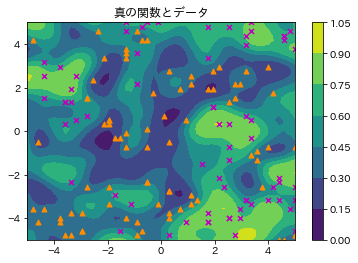

In [126]:
grid_N = 50
x = np.linspace(-5.0, 5.0, grid_N)
X1_grid, X2_grid = np.meshgrid(x, x)
X12_grid = np.array([[x1, x2] for x1, x2 in zip(X1_grid.ravel(), X2_grid.ravel())])
X12_grid = torch.from_numpy(X12_grid).float()

kernel = gpytorch.kernels.RBFKernel()
K = kernel.forward(X12_grid, X12_grid).detach().numpy()
f = np.random.multivariate_normal(mean = np.zeros(grid_N**2), cov=K)

sigmoid = lambda x: 1/(1+np.exp(-x))
Y = sigmoid(f)
Y_grid = Y.reshape(grid_N, grid_N)

threshhold = lambda x : 1 if x >=0.5 else 0
Y_binary_grid = torch.tensor(list(map(threshhold,Y)))

N = 150
sample_index = np.random.choice(np.arange(grid_N**2,), N)
x_data = X12_grid[sample_index].clone().float()
y_data = Y_binary_grid[sample_index].clone().float()

fig, ax = plt.subplots(figsize=(6, 4))
image = ax.contourf(X1_grid, X2_grid, Y_grid)
x_data_1 = x_data[y_data==0]
x_data_2 = x_data[y_data==1]
ax.scatter(x=x_data_1[:, 0], y=x_data_1[:, 1], color="darkorange", marker="^", s=25)
ax.scatter(x=x_data_2[:, 0], y=x_data_2[:, 1], color="m", marker="x", s=25)
plt.colorbar(image)
ax.set_title("真の関数とデータ")

In [127]:
from gpytorch.models import ApproximateGP
from gpytorch.variational import CholeskyVariationalDistribution, UnwhitenedVariationalStrategy, VariationalStrategy

In [128]:
class GPclassifcationModel(ApproximateGP):
    def __init__(self, train_x):
        variational_distribution = CholeskyVariationalDistribution(train_x.size(0))
        variational_strategy = UnwhitenedVariationalStrategy(self, train_x, variational_distribution, learn_inducing_locations=False)
        # variational_strategy = VariationalStrategy(self, train_x, variational_distribution, learn_inducing_locations=False)
        super(GPclassifcationModel, self).__init__(variational_strategy)
        
        self.mean_module = gpytorch.means.ConstantMean()
        
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel(2))
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        latent_pred = gpytorch.distributions.MultivariateNormal(mean_x, covar_x)
        return latent_pred

In [129]:
model = GPclassifcationModel(x_data)
likelihood = gpytorch.likelihoods.BernoulliLikelihood()

In [130]:
model.train()
likelihood.train()

model.covar_module.base_kernel.lengthscale = torch.tensor([0.6931, 0.6931])
all_params = set(model.parameters())
fix_params = {model.covar_module.base_kernel.raw_lengthscale}
opt_params = list(all_params - fix_params)

optimizer = torch.optim.Adam(opt_params, lr=0.1)

mll = gpytorch.mlls.VariationalELBO(likelihood, model, y_data.numel())
training_iter = 200
loss_list = []
for i in range(training_iter):
    optimizer.zero_grad()
    output = model(x_data)
    loss = -mll(output, y_data)
    loss.backward()
    loss_list.append(loss.item())
    optimizer.step()

Text(0, 0.5, 'Loss')

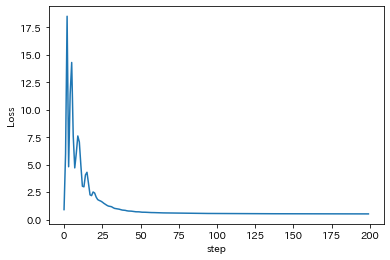

In [131]:
plt.plot(loss_list)
plt.xlabel("step")
plt.ylabel("Loss")

In [135]:
model.eval()
likelihood.eval()
with torch.no_grad():
    f_dist = model(X12_grid)
    mean = f_dist.mean
    
    f_lower, f_upper = f_dist.confidence_region()    
    y_dist = likelihood(f_dist)

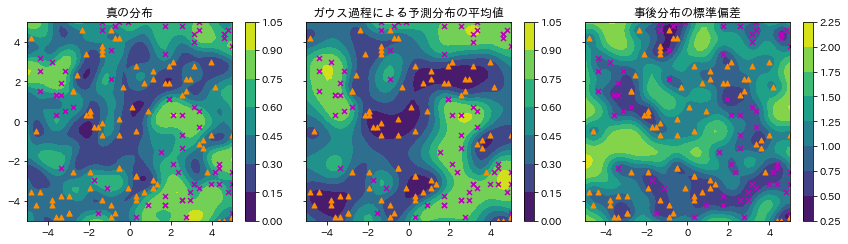

In [139]:
fig, ax = plt.subplots(figsize=(12, 3.5), ncols=3, sharex = True, sharey = True)

image1 = ax[0].contourf(X1_grid, X2_grid, Y_grid)
image2 = ax[1].contourf(X1_grid, X2_grid, y_dist.mean.numpy().reshape(grid_N,grid_N))
image3 = ax[2].contourf(X1_grid, X2_grid, f_dist.covariance_matrix.diag().detach().numpy().reshape(grid_N, grid_N))
for i in range(3):
    ax[i].scatter(x=x_data_1[:,0], y=x_data_1[:, 1], color="darkorange", marker="^", s=25)
    ax[i].scatter(x=x_data_2[:,0], y=x_data_2[:, 1], color="m", marker="x", s = 25)
ax[0].set_title("真の分布")
ax[1].set_title("ガウス過程による予測分布の平均値")
ax[2].set_title("事後分布の標準偏差")

plt.colorbar(image1, ax=ax[0]);plt.colorbar(image2, ax=ax[1]);plt.colorbar(image3, ax=ax[2])
plt.tight_layout()

In [41]:
for x in dir(model):
    print (x, ':', type(eval("model."+x)))

T_destination : <class 'typing.TypeVar'>
__annotations__ : <class 'dict'>
__call__ : <class 'method'>
__class__ : <class 'type'>
__delattr__ : <class 'method'>
__dict__ : <class 'dict'>
__dir__ : <class 'method'>
__doc__ : <class 'NoneType'>
__eq__ : <class 'method-wrapper'>
__format__ : <class 'builtin_function_or_method'>
__ge__ : <class 'method-wrapper'>
__getattr__ : <class 'method'>
__getattribute__ : <class 'method-wrapper'>
__gt__ : <class 'method-wrapper'>
__hash__ : <class 'method-wrapper'>
__init__ : <class 'method'>
__init_subclass__ : <class 'builtin_function_or_method'>
__le__ : <class 'method-wrapper'>
__lt__ : <class 'method-wrapper'>
__module__ : <class 'str'>
__ne__ : <class 'method-wrapper'>
__new__ : <class 'builtin_function_or_method'>
__reduce__ : <class 'builtin_function_or_method'>
__reduce_ex__ : <class 'builtin_function_or_method'>
__repr__ : <class 'method'>
__setattr__ : <class 'method'>
__setstate__ : <class 'method'>
__sizeof__ : <class 'builtin_function_or